In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import copy
from sklearn.metrics import make_scorer, mean_squared_error

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap, root_mean_squared_error, get_reg, get_stratified_cv, cross_val_score_nuis, get_fdr_p

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 200 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

In [5]:
# output file prefix
run_hemi = ''
if run_hemi == 'ipsi':
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_ipsi_'
elif run_hemi == 'contra':
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_contra_'
else:
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_200_streamlineCount_'

In [6]:
# drop brainstem
if parc_str == 'lausanne':
    parcel_loc = parcel_loc[parcel_loc != 2]
#     parcel_loc = parcel_loc[parcel_loc == 1]
    num_parcels = len(parcel_loc[parcel_loc == 1])

### Setup directory variables

In [7]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [8]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


In [9]:
# phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
# phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
# phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

# print(phenos)

# metrics = ['str', 'ac', 'bc', 'cc', 'sgc']
# metrics_label = ['Strength', 'Average controllability', 'Betweenness centrality', 'Closeness centrality', 'Subgraph centrality']

algs = ['rr', 'krr_rbf']
scores = ['corr', 'rmse']
seeds = np.arange(0,100)

### Model options

In [10]:
a = 1; alg = algs[a]; print(alg)
s = 1; score = scores[s]; print(score)

krr_rbf
rmse


In [11]:
my_scorer = make_scorer(root_mean_squared_error, greater_is_better = False)
my_scorer

make_scorer(root_mean_squared_error, greater_is_better=False)

In [12]:
regs, param_grid = get_reg()
# regs = get_reg()

In [13]:
n_splits = 10

In [14]:
g = 0
gradient = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '2_compute_gradient', 'out', parc_str+'_'+str(parc_scale)+'_'+'pnc_grads_template.txt'))[:,g]
# sort gradient
sort_idx = np.argsort(gradient)

## Setup plots

In [15]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})
cmap = my_get_cmap('pair')

## Load data

In [16]:
df_node = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

df_node_ac_overc = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X_ac_c.csv'))
df_node_ac_overc.set_index(['bblid', 'scanid'], inplace = True)

df_node_ac_i2 = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X_ac_i2.csv'))
df_node_ac_i2.set_index(['bblid', 'scanid'], inplace = True)

df_node_ac_overc_i2 = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'X_ac_c_i2.csv'))
df_node_ac_overc_i2.set_index(['bblid', 'scanid'], inplace = True)

df_pheno = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'y.csv'))
df_pheno.set_index(['bblid', 'scanid'], inplace = True)

c = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'c.csv'))
c.set_index(['bblid', 'scanid'], inplace = True); print(c.shape)
c.columns

(1068, 4)


Index(['ageAtScan1', 'sex', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS'], dtype='object')

In [17]:
print(np.all(df_node.filter(regex = 'ac') == df_node_ac_i2))
print(np.sum(df_node.filter(regex = 'ac').corrwith(df_node_ac_i2, method='spearman') < 0.99))

print(np.all(df_node_ac_overc == df_node_ac_overc_i2))
print(np.sum(df_node_ac_overc.corrwith(df_node_ac_overc_i2, method='spearman') < 0.99))

True
0
True
0


In [18]:
# # replace ac with initial condition = 2
# ac_labels = ['ac_' + str(i) for i in range(num_parcels)]
# df_node.loc[:,ac_labels]

In [19]:
(np.sum(c.loc[:,'sex'] == 1)/c.shape[0]) * 100

45.50561797752809

In [20]:
print(num_parcels)

# num_windows = 40
# print(num_parcels/num_windows)
# bin_size = int(num_parcels/num_windows)
bin_size = 5

print(bin_size)
print(num_parcels % bin_size)

200
5
0


In [21]:
if num_parcels % bin_size == 0:
    window_start = np.arange(0,num_parcels - bin_size + 1, bin_size)
else:
    window_start = np.arange(0,num_parcels, bin_size)
    
num_windows = len(window_start)

print(window_start)
print(num_windows)

# if window_start[-1]+bin_size != num_parcels:
#     print('Warning: check bins')
#     window_start = np.append(window_start, num_parcels-bin_size)
#     num_windows = len(window_start)
#     print(window_start)
#     print(num_windows)

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195]
40


### Export for permutation testing on cluster

In [22]:
if parc_str == 'schaefer' and parc_scale == 200:
    outputdir = os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out_gradient_bin')
    print(outputdir)
    if not os.path.exists(outputdir):
        os.makedirs(outputdir)

        metrics = ['str', 'ac']

        for metric in metrics:
            X = df_node.filter(regex = metric)

            # reorder X by gradient
            X_sort_grad = X.iloc[:,sort_idx]

            for i, w in enumerate(window_start):
                Xl = X_sort_grad.iloc[:,w:w+bin_size]
                Xl.to_csv(os.path.join(outputdir, outfile_prefix+'X_'+metric+'_bin_'+str(i)+'.csv'))

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/1_compute_node_features/out_gradient_bin


## Plot

In [23]:
metrics = ['str', 'ac']
metrics_label = ['Strength', 'Average controllability']
phenos = ['Psychosis_Positive',]
phenos_label = ['Psychosis (positive)',]
phenos_short = ['Psy. (pos)',]

### Stratified cv, w/ permutation
Note, won't run if cluster jobs haven't been run

In [24]:
predictiondir = os.path.join(os.environ['PIPELINEDIR'], '3_prediction_rnr', 'out', outfile_prefix)
indir = predictiondir + 'predict_symptoms_scv_nuis_gradient'
indir

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/3_prediction_rnr/out/schaefer_200_streamlineCount_predict_symptoms_scv_nuis_gradient'

In [25]:
if os.path.exists(indir):
    # compute accuracy for non overlapping windows
    window_sterr = np.zeros((len(metrics), len(phenos), num_windows))
    window_score = np.zeros((len(metrics), len(phenos), num_windows))
    stats_permutation = np.zeros((len(metrics), len(phenos), num_windows))

    my_r = pd.DataFrame(index = metrics, columns = phenos)
    my_pvals = pd.DataFrame(index = metrics, columns = phenos)

    for m, metric in enumerate(metrics):
        for p, pheno in enumerate(phenos):
            print(metric, pheno)

            for i in np.arange(num_windows):
                accuracy = np.loadtxt(os.path.join(indir, 'bin_'+str(i), alg + '_' + score + '_' + metric + '_' + pheno, 'accuracy_nuis.txt'))[:10000]
                window_sterr[m,p,i] = np.std(accuracy) / np.sqrt(n_splits)
                window_score[m,p,i] = np.mean(accuracy)

                permuted_acc = np.loadtxt(os.path.join(indir, 'bin_'+str(i), alg + '_' + score + '_' + metric + '_' + pheno, 'permuted_acc_nuis.txt'))
                stats_permutation[m,p,i] = np.sum(permuted_acc >= window_score[m,p,i]) / len(permuted_acc)

    #         stats_permutation[m,p,:] = get_fdr_p(stats_permutation[m,p,:])

            if score == 'rmse': window_score[m,p,:] = np.abs(window_score[m,p,:])

            my_r.loc[metric,pheno] = sp.stats.pearsonr(window_start, window_score[m,p,:])[0]
            my_pvals.loc[metric,pheno] = sp.stats.pearsonr(window_start, window_score[m,p,:])[1]
else:
    print('Skipping... run cluster jobs first')

str Psychosis_Positive
ac Psychosis_Positive


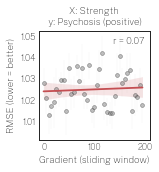

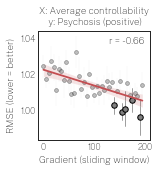

In [26]:
if os.path.exists(indir):
    for m, metric in enumerate(metrics):
        for p, pheno in enumerate(phenos):

            # plot
            f, ax = plt.subplots()
            f.set_figwidth(2)
            f.set_figheight(2)
            sns.regplot(x = window_start, y = window_score[m,p,:], color = 'r', scatter = False, ax=ax)

            # non overlapping windows
            for i in np.arange(num_windows):

                if stats_permutation[m,p,i] < 0.05:
                    ax.scatter(x = window_start[i], y = window_score[m,p,i], marker = 'o', s = 30, edgecolors = 'black', facecolors = 'gray', alpha=1, linewidth = 1)
                    ax.plot([window_start[i], window_start[i]], [window_score[m,p,i], window_score[m,p,i]-window_sterr[m,p,i]], color = 'gray', alpha=1, linewidth = 0.75, zorder=0)
                    ax.plot([window_start[i], window_start[i]], [window_score[m,p,i], window_score[m,p,i]+window_sterr[m,p,i]], color = 'gray', alpha=1, linewidth = 0.75, zorder=0)
                else:
                    ax.scatter(x = window_start[i], y = window_score[m,p,i], marker = 'o', s = 15, edgecolors = 'black', facecolors = 'gray', alpha=0.5, linewidth = 0.5)
                    ax.plot([window_start[i], window_start[i]], [window_score[m,p,i], window_score[m,p,i]-window_sterr[m,p,i]], color = 'gray', alpha=0.2, linewidth = 0.25, zorder=0)
                    ax.plot([window_start[i], window_start[i]], [window_score[m,p,i], window_score[m,p,i]+window_sterr[m,p,i]], color = 'gray', alpha=0.2, linewidth = 0.25, zorder=0)

            ax.tick_params(pad = -2)

            ax.set_xlabel('Gradient (sliding window)')
            ax.set_ylabel('RMSE (lower = better)')
            ax.set_xlim([-10, num_parcels+10])
            ax.set_title('X: ' + metrics_label[m] + '\n y: ' + phenos_label[p])
            
            textstr = 'r = {:.2f}'.format(my_r.loc[metric].values[0])
            ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
                    verticalalignment='top', horizontalalignment='right')

            f.savefig(outfile_prefix+'gradient_'+str(g)+'_window_'+metric+'_'+pheno+'_null.svg', dpi = 300, bbox_inches = 'tight')
else:
    print('Skipping... run cluster jobs first')

In [27]:
if os.path.exists(indir):
    print(my_r)

    Psychosis_Positive
str          0.0673871
ac           -0.663308


In [28]:
sns.set(style='white', context = 'paper', font_scale = 0.8)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})

In [29]:
c_params = np.array([10, 100, 1000, 10000])
c_params

control_c = c_params[-1]
# control_c = None
print(control_c)

# metrics = ['str', 'ac', 'bc', 'cc', 'sgc']
# metrics_label = ['Strength', 'Average controllability', 'Betweenness centrality', 'Closeness centrality', 'Subgraph centrality']
# phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
# phenos_label = ['Overall psychopathology','Psychosis (positive)','Psychosis (negative)']

metrics = ['ac',]
metrics_label = ['Average controllability',]
phenos = ['Psychosis_Positive',]
phenos_label = ['Psychosis (positive)',]

10000


In [30]:
# # age split

# # age_split = c['ageAtScan1'] < c['ageAtScan1'].mean()
# age_split = c['ageAtScan1'] > c['ageAtScan1'].mean()

# c = c.loc[age_split,:]
# c.drop(labels=['ageAtScan1'], axis=1, inplace=True)

# df_node = df_node.loc[age_split,:]

# df_node_ac_overc = df_node_ac_overc.loc[age_split,:]
# df_node_ac_i2 = df_node_ac_i2.loc[age_split,:]
# df_node_ac_overc_i2 = df_node_ac_overc_i2.loc[age_split,:]

# df_pheno = df_pheno.loc[age_split,:]

# metrics = ['str', 'ac']
# metrics_label = ['Strength', 'Average controllability']
# phenos = ['Psychosis_Positive',]
# phenos_label = ['Psychosis (positive)',]

ac Psychosis_Positive
(1068, 200)
(1068,)
Full model score: 1.0172230220092318 0.007612095251709088
Computing accuracy for non overlapping windows


/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator


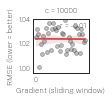

In [31]:
my_r = pd.DataFrame(index = metrics, columns = phenos)
my_pvals = pd.DataFrame(index = metrics, columns = phenos)

for m, metric in enumerate(metrics):
    for p, pheno in enumerate(phenos):
        print(metric, pheno)
        
        # Get X and y data
        if control_c == None:
            X = df_node.filter(regex = metric)
        else:
            X = df_node_ac_overc.filter(regex = metric + '_c' + str(control_c) + '_')
        
        if parc_str == 'lausanne':
            X = X.iloc[:,parcel_loc==1]
        print(X.shape)
        
        y = df_pheno.loc[:,pheno]; print(y.shape)

        # set regression estimator
        reg = copy.deepcopy(regs[alg])
    
        # sort and get cross-val
        X_sort, y_sort, my_cv, c_sort = get_stratified_cv(X = X, y = y, c = c, n_splits = n_splits)

        # get full model score
        nuis_model, _ = cross_val_score_nuis(X = X_sort, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
        if score == 'rmse': nuis_model = np.abs(nuis_model)
        main_score_nuis = nuis_model.mean()
        main_sterr_nuis = nuis_model.std() / np.sqrt(n_splits)
        print('Full model score:', main_score_nuis, main_sterr_nuis)
        
        print('Computing accuracy for non overlapping windows')
        # reorder X by gradient
        X_sort_grad = X_sort.iloc[:,sort_idx]

        # compute accuracy for non overlapping windows
        window_score = np.zeros(num_windows,)
        window_sterr = np.zeros(num_windows,)

        for i, w in enumerate(window_start):
            Xl = X_sort_grad.iloc[:,w:w+bin_size]
            cv_results, _ = cross_val_score_nuis(X = Xl, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
            if score == 'rmse': cv_results = np.abs(cv_results)
            window_score[i] = cv_results.mean()
            window_sterr[i] = cv_results.std() / np.sqrt(n_splits)

        my_r.loc[metric,pheno] = sp.stats.pearsonr(window_start, window_score)[0]
        my_pvals.loc[metric,pheno] = sp.stats.pearsonr(window_start, window_score)[1]
            
        # plot
        f, ax = plt.subplots()
#         f.set_figwidth(1.25)
#         f.set_figheight(1.25)
        f.set_figwidth(1)
        f.set_figheight(1)
        sns.regplot(x = window_start, y = window_score, color = 'r', scatter = False)
        
        # non overlapping windows
        if len(window_start) > len(window_score): window_start = window_start[:len(window_score)]
        ax.scatter(x = window_start, y = window_score, marker = 'o', s = 15, edgecolors = 'black', facecolors = 'gray', alpha=0.5, linewidth = 0.5)
        ax.tick_params(pad = -2)

        ax.set_xlabel('Gradient (sliding window)')
        if score == 'rmse': ax.set_ylabel('RMSE (lower = better)')
        if score == 'corr': ax.set_ylabel('Correlation (higher = better)')
        ax.set_xlim([-10, num_parcels+10])
        ax.set_xticklabels(['','0','',str(num_windows)])
        if control_c != None:
            ax.set_ylim([0.995, 1.04])

        if control_c == None:
            ax.set_title('X: ' + metrics_label[m] + '\n y: ' + phenos_label[p])
        else:
            ax.set_title('c = ' + str(control_c))
                    
        textstr = 'r = {:.2f}'.format(my_r.loc[metric,pheno])
        ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right')

        if control_c == None:
            f.savefig(outfile_prefix+'gradient_'+str(g)+'_window_'+metric+'_'+pheno+'.svg', dpi = 300, bbox_inches = 'tight')
        else:
            f.savefig(outfile_prefix+'c_' + str(control_c) + '_gradient_'+str(g)+'_window_'+metric+'_'+pheno+'.svg', dpi = 300, bbox_inches = 'tight')

In [32]:
my_r

,Psychosis_Positive
ac,-0.00906994
